In [4]:

import os
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__vsc_ipynb_file__), '../../')))
from gestures import config11 as cfg
from gestures.data_loader.tiny_data_loader import get_tiny_data_loader


In [2]:

def doppler_map(x: np.ndarray, ax: int = 1) -> np.ndarray:
    """input shape is (N,doppler_points,range_points)"""
    if ax == 1:
        assert x.ndim == 3, f"ax is {ax} so data must be 3D"
    if ax == 0:
        assert x.ndim == 2, f"ax is {ax} so data must be 2D"
    return np.abs(fftshift(fft(x, axis=ax), axes=ax))


def show_res(res:dict, num:int):
    high_res = res['true'][0][num].detach().numpy()
    high_res_l1 = res['pred_l1_loss'][0][num].detach().numpy()
    high_res_ms = res['pred_ms_loss'][0][num].detach().numpy()
    doppler_l1 = doppler_map(high_res_l1[0] + 1j * high_res_l1[1], ax=0)
    doppler_ms = doppler_map(high_res_ms[0] + 1j * high_res_ms[1], ax=0)
    doppler_true = doppler_map(high_res[0] + 1j * high_res[1], ax=0)
    plt.figure(figsize=(20, 20))
    plt.imshow(doppler_true)
    plt.title("True")
    plt.figure(figsize=(20, 20))

    plt.imshow(doppler_l1)
    plt.title("L1")
    plt.figure(figsize=(20, 20))

    plt.imshow(doppler_ms)
    plt.title("MS")
    
    mse_l1 = np.mean(np.square(high_res_l1 - high_res))
    mse_ms = np.mean(np.square(high_res_ms - high_res))
    print(f"L2 loss L1: {mse_l1}")
    print(f"L2 loss MS: {mse_ms}")
    


In [5]:
from gestures.main import get_pc_cgf


pc = cfg.pc
data_dir, output_dir, device = get_pc_cgf(pc)

# getting data loaders
data_cfg = cfg.data_cfg
data_preprocessing_cfg = cfg.data_preprocessing_cfg
trainloader, valloader,ttt = get_tiny_data_loader(
    data_dir=data_dir,
    data_scg=data_cfg,
    data_preprocessing_cfg=data_preprocessing_cfg,
    use_pool=False,
    batch_size=cfg.batch_size,
)

loading data with 8 cpu cores


In [4]:
for x,y in trainloader:
    break
y[0].shape

torch.Size([10, 5, 2, 2, 32, 492])

In [14]:
x.shape

torch.Size([10, 5, 2, 2, 8, 123])

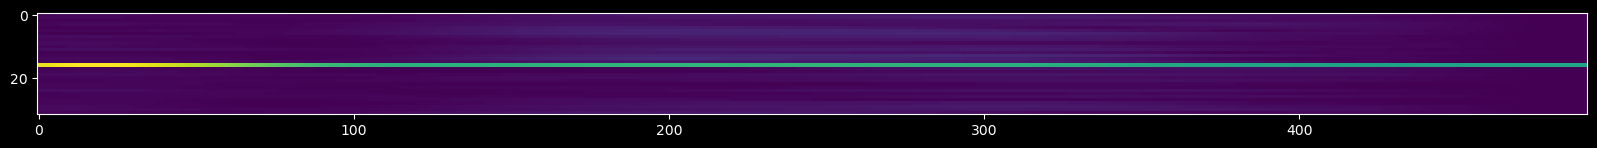

In [22]:
img = y[0][6,0,0].numpy()
plt.figure(figsize=(20, 20))
plt.imshow(doppler_map(img[0]+1j*img[1], ax=0))

In [11]:
from gestures.network.models.basic_model import BasicModel
path_l1 = "/Users/netanelblumenfeld/Desktop/bgu/Msc/code/outputs/sr/Drln_2_loss_L1_1/ds_4_original_dim_False_pix_norm_Normalization.Range_0_1/2024-02-09_15:03:43/model/loss.pth"
path_l1_msssim = "/Users/netanelblumenfeld/Desktop/bgu/Msc/code/outputs/sr/Drln_2_loss_L1_0.5_MsssimLoss_0.5/ds_4_original_dim_False_pix_norm_Normalization.Range_0_1/2024-02-06_08:51:42/model/loss.pth"
model_l1,*_ = BasicModel.load_model(device,path_l1)
model_l1_msssim,*_ = BasicModel.load_model(device,path_l1_msssim)

In [23]:
model_l1.eval()
res_l1 = model_l1(x[6,0])

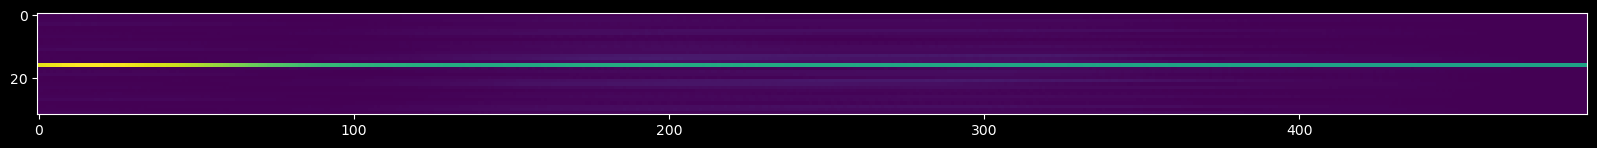

In [24]:
imgr = res_l1[0].detach().numpy()
plt.figure(figsize=(20, 20))
plt.imshow(doppler_map(imgr[0]+1j*imgr[1], ax=0))

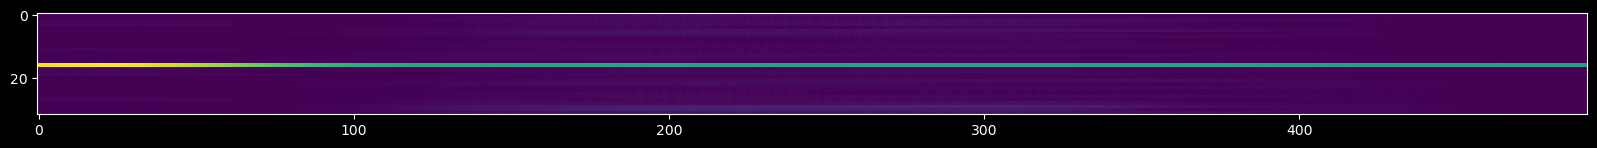

In [28]:
model_l1_msssim.eval()
res_l1_msssim = model_l1_msssim(x[6,0])
imgr = res_l1_msssim[0].detach().numpy()
plt.figure(figsize=(20, 20))
plt.imshow(doppler_map(imgr[0]+1j*imgr[1], ax=0))

In [5]:


from gestures.network.models.super_resolution.drln import Drln


path_ms = "/Users/netanelblumenfeld/Desktop/bgu/Msc/4090/Radar/outputs/models/sr/Drln_2/lr_0.0018_batch_size_64_loss_MSSSIML1/2024-01-15_17:03:18fffmin_loss_model.pt"
path_l1 = "/Users/netanelblumenfeld/Desktop/bgu/Msc/4090/Radar/outputs/models/sr/Drln_2/ds_4_original_dim_False_pix_norm_Normalization.Range_0_1/lr_0.0015_batch_size_64_loss_L1/2024-01-11_14:43:43min_loss_model.pt"
optimizeer = torch.optim.Adam
drln = Drln
args = {'num_drln_blocks' : 2, 'scale': 4, 'num_channels':  2}
model_ms,a,b,ms = drln.load_model(path_ms, optimizeer, {'lr':0.001},device=device, **args)
model_l1,a,b,l1 = drln.load_model(path_l1, optimizeer, {'lr':0.001},device=device, **args)
model_ms.eval()
model_l1.eval()

print(ms,l1)


0.20212459357838525 0.07520895775377266


In [3]:
# x = torch.randn(1, 3, 427, 240)
from gestures.network.models.super_resolution.safmn import SAFMN


x = torch.randn(1, 2, 320, 180)
# x = torch.randn(1, 3, 256, 256)

model = SAFMN(dim=36, n_blocks=8, ffn_scale=2.0, upscaling_factor=4)
# model = SAFMN(dim=36, n_blocks=12, ffn_scale=2.0, upscaling_factor=2)
print(model)
print(f"params: {sum(map(lambda x: x.numel(), model.parameters()))}")
output = model(x)
print(output.shape)


SAFMN(
  (to_feat): Conv2d(2, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (feats): Sequential(
    (0): AttBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (safm): SAFM(
        (mfr): ModuleList(
          (0-3): 4 x Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=9)
        )
        (aggr): Conv2d(36, 36, kernel_size=(1, 1), stride=(1, 1))
        (act): GELU(approximate='none')
      )
      (ccm): CCM(
        (ccm): Sequential(
          (0): Conv2d(36, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GELU(approximate='none')
          (2): Conv2d(72, 36, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
    (1): AttBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (safm): SAFM(
        (mfr): ModuleList(
          (0-3): 4 x Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=9)
        )
        (aggr): Conv2d(36, 36, kernel_size=(1, 1), stride=(1, 1))
       